# Imports

In [1]:
import pandas as pd
import numpy as np

# Read data

In [2]:
df = pd.read_csv('/kaggle/input/ibm-classification-feature-engineering/all_data.csv')
df.drop('Unnamed: 0', inplace=True, axis=1)

In [3]:
df.head(5)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,S&P500,Exchange_BTS,...,9-day Backward Return,11-day Backward Return,13-day Backward Return,15-day Backward Return,17-day Backward Return,19-day Backward Return,21-day Backward Return,23-day Backward Return,25-day Backward Return,3-week Forward Excess Return Sign
0,1,190,85.352966,112.374580,113.921402,112.366219,113.553513,3357770.0,1845.04,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1,261,140.460007,140.460007,144.199997,136.009995,141.339996,2618100.0,1845.04,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
2,1,297,47.366394,51.546665,52.286667,51.459999,52.099998,961800.0,1845.04,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,1,235,NaN,NaN,NaN,NaN,NaN,NaN,1845.04,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,324,33.661797,48.000000,48.750000,47.889999,48.299999,1019600.0,1845.04,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


# Feature Selection

Throughout this notebook, we use this article on feature selection to help out https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection

We should only perform feature selection on our training set to avoid overfitting so we split our data below. We start from Date 26 so that we don't have NaNs for backward looking returns. Similarly, we cut off our test set to not include the last dates where we don't have forward looking returns.

In [4]:
# Training set
X_train = df[(df['Date'] <= 2000) & (df['Date'] >= 26)]
y_train = X_train['3-week Forward Excess Return Sign']
X_train.drop('3-week Forward Excess Return Sign', inplace=True, axis=1)

# Test set
X_test = df[(df['Date'] > 2000) & (df['Date'] <= 2502)]
y_test = X_test['3-week Forward Excess Return Sign']
X_test.drop('3-week Forward Excess Return Sign', inplace=True, axis=1)

# Print shapes
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

/tmp/ipykernel_18/352149026.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop('3-week Forward Excess Return Sign', inplace=True, axis=1)


X_train: (993425, 259)
y_train: (993425,)
X_test: (252506, 259)
y_test: (252506,)


/tmp/ipykernel_18/352149026.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('3-week Forward Excess Return Sign', inplace=True, axis=1)


## Filter Methods

Filter methods are generally used as a preprocessing step. The selection of features is independent of any machine learning algorithms. Instead, features are selected on the basis of their scores in various statistical tests for their correlation with the outcome variable. For classification problems like this one, correlation-based filter methods tend to yield the best results and are less computationally expensive than training a model and doing some sort of recursive feature selection.

### Remove low variance features

In [5]:
# Check if any features have 0 variance
from sklearn.feature_selection import VarianceThreshold
zero_threshold = VarianceThreshold(threshold=0)
zero_threshold.fit(X_train)
num_constant_features = len(X_train.columns) - sum(zero_threshold.get_support())
print(f"There are {num_constant_features} constant features")

There are 0 constant features


In [6]:
# Find 'almost' constant features
almost_constant_threshold = VarianceThreshold(threshold=0.01)
almost_constant_threshold.fit(X_train)
num_almost_constant_features = len(X_train.columns) - sum(almost_constant_threshold.get_support())
print(f"There are {num_almost_constant_features} almost constant features")
print([c for c in X_train.columns if c not in X_train.columns[almost_constant_threshold.get_support()]])

# Remove 'almost constant' features
X_train = pd.DataFrame(almost_constant_threshold.transform(X_train), columns=X_train.columns[almost_constant_threshold.get_support()])
X_test = pd.DataFrame(almost_constant_threshold.transform(X_test), columns=X_test.columns[almost_constant_threshold.get_support()])

# Check shapes to ensure features have been removed
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

There are 120 almost constant features
['Exchange_BTS', 'Exchange_NGM', 'Industry_Advertising Agencies', 'Industry_Agricultural Inputs', 'Industry_Airlines', 'Industry_Apparel Manufacturing', 'Industry_Apparel Retail', 'Industry_Auto & Truck Dealerships', 'Industry_Auto Manufacturers', 'Industry_Auto Parts', 'Industry_Banks - Diversified', 'Industry_Beverages - Brewers', 'Industry_Beverages - Non-Alcoholic', 'Industry_Beverages - Wineries & Distilleries', 'Industry_Biotechnology', 'Industry_Building Materials', 'Industry_Building Products & Equipment', 'Industry_Capital Markets', 'Industry_Chemicals', 'Industry_Communication Equipment', 'Industry_Confectioners', 'Industry_Conglomerates', 'Industry_Consulting Services', 'Industry_Consumer Electronics', 'Industry_Copper', 'Industry_Discount Stores', 'Industry_Drug Manufacturers - Specialty & Generic', 'Industry_Electrical Equipment & Parts', 'Industry_Electronic Components', 'Industry_Electronic Gaming & Multimedia', 'Industry_Engineerin

In [7]:
X_train

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,S&P500,Exchange_NMS,...,Volume vs 26-Day Lower BB,MACD,MACD Signal Line,MACD Histogram,Yesterday Adj Close,True Range,26-Day Average True Range,MACD-V,MACD-V Signal Line,MACD-V Histogram
0,26.0,299.0,59.086494,80.300003,80.709999,80.010002,80.489998,8515500.0,1897.45,1.0,...,5.405834e+06,1.330942,NaN,NaN,59.123264,21.586735,20.329094,6.546980,NaN,NaN
1,26.0,457.0,38.959488,47.060001,47.080002,46.349998,46.520000,1142600.0,1897.45,0.0,...,7.396864e+05,0.195522,NaN,NaN,38.338589,8.741413,8.188713,2.387700,NaN,NaN
2,26.0,469.0,74.599998,74.599998,76.480003,74.580002,76.050003,430100.0,1897.45,1.0,...,2.904636e+05,-0.026833,NaN,NaN,75.879997,1.900002,1.641540,-1.634644,NaN,NaN
3,26.0,156.0,1094.219971,1094.219971,1111.000000,1091.500000,1105.369995,26000.0,1897.45,0.0,...,2.824287e+04,-2.187924,NaN,NaN,1103.270020,19.500000,24.968849,-8.762617,NaN,NaN
4,26.0,120.0,19.510111,31.099445,31.108761,30.829340,30.894539,4647842.0,1897.45,0.0,...,2.369710e+06,0.051106,NaN,NaN,19.346506,11.762255,11.462619,0.445851,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993420,2000.0,315.0,95.449997,95.449997,95.959999,94.389999,94.959999,3272100.0,4262.45,0.0,...,1.408067e+06,-1.652699,-1.769498,0.116799,93.989998,1.970001,2.862692,-57.732331,-59.924296,2.191965
993421,2000.0,485.0,167.012650,173.509995,173.919998,171.320007,171.320007,332500.0,4262.45,0.0,...,3.004240e+05,3.272948,3.203946,0.069002,164.250107,9.669891,9.107181,35.938103,35.731479,0.206623
993422,2000.0,488.0,20.974371,22.340000,22.420000,21.840000,21.889999,4247700.0,4262.45,0.0,...,2.087115e+06,0.007578,-0.137355,0.144934,20.392269,2.027731,1.688806,0.448742,-8.319989,8.768731
993423,2000.0,237.0,21.277412,23.840000,24.160000,23.490000,23.969999,6940200.0,4262.45,0.0,...,2.666872e+06,-0.473585,-0.449641,-0.023944,21.250637,2.909363,3.126647,-15.146744,-14.313011,-0.833733


# NEED TO CHECK WHY BACKWARD RETURNS HAVE SO LITTLE VARIANCE??

### Remove highly correlated features using correlation matrix

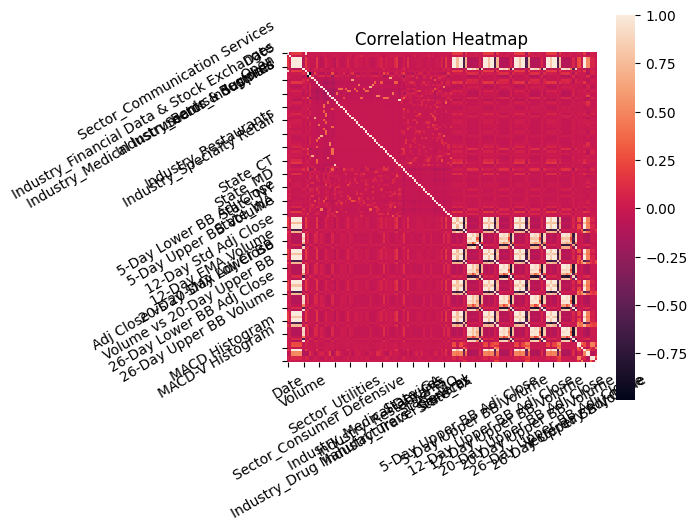

In [8]:
# Create correlation matrix of remaining features
corr_matrix = X_train.corr()

# Create correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
plt.title('Correlation Heatmap')
a = sns.heatmap(corr_matrix, square=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show() 

In [9]:
# Get columns of correlation matrix that have high correlation to other features (need upper triangular matrix to stop wrong features being dropped)
correlation_threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in list(upper.columns) if any(upper[column] > correlation_threshold)]
print(to_drop)  

['Close', 'High', 'Low', 'Open', 'S&P500', '5-Day SMA Adj Close', '5-Day EMA Adj Close', '5-Day Upper BB Adj Close', '5-Day Lower BB Adj Close', '5-Day SMA Volume', '5-Day EMA Volume', '5-Day Upper BB Volume', '12-Day SMA Adj Close', '12-Day EMA Adj Close', '12-Day Upper BB Adj Close', '12-Day Lower BB Adj Close', '12-Day SMA Volume', '12-Day EMA Volume', '12-Day Std Volume', '12-Day Upper BB Volume', 'Volume vs 12-Day Lower BB', '20-Day SMA Adj Close', '20-Day EMA Adj Close', '20-Day Std Adj Close', '20-Day Upper BB Adj Close', '20-Day Lower BB Adj Close', 'Adj Close vs 20-Day Upper BB', 'Adj Close vs 20-Day Lower BB', '20-Day SMA Volume', '20-Day EMA Volume', '20-Day Std Volume', '20-Day Upper BB Volume', 'Volume vs 20-Day Upper BB', 'Volume vs 20-Day Lower BB', '26-Day SMA Adj Close', '26-Day EMA Adj Close', '26-Day Std Adj Close', '26-Day Upper BB Adj Close', '26-Day Lower BB Adj Close', 'Adj Close vs 26-Day Upper BB', 'Adj Close vs 26-Day Lower BB', '26-Day SMA Volume', '26-Day EM

In [10]:
# Drop highyl correlated features from X_train and X_test
X_train.drop(to_drop, axis=1, inplace=True)
X_test.drop(to_drop, axis=1, inplace=True)

# Check shapes to ensure features have been removed
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (993425, 87)
X_test: (252506, 87)


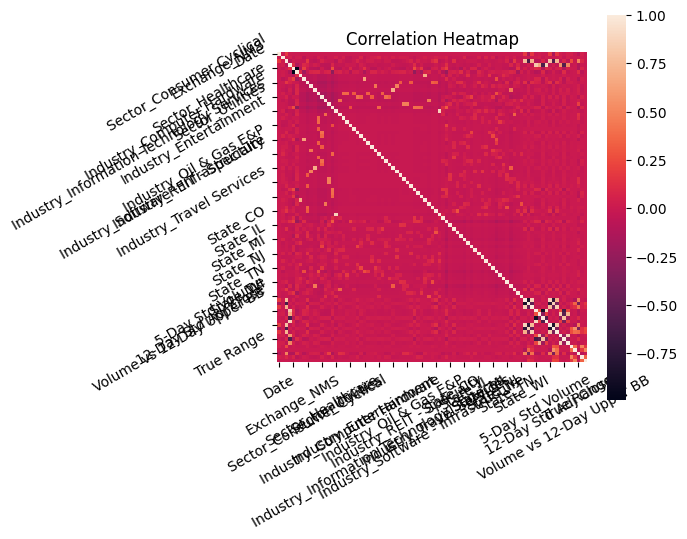

In [11]:
# Create correlation matrix of remaining features
corr_matrix = X_train.corr()

# Create correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
plt.title('Correlation Heatmap')
a = sns.heatmap(corr_matrix, square=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show() 

In [12]:
X_train.columns

Index(['Date', 'Symbol', 'Adj Close', 'Volume', 'Exchange_NMS', 'Exchange_NYQ',
       'Sector_Basic Materials', 'Sector_Communication Services',
       'Sector_Consumer Cyclical', 'Sector_Consumer Defensive',
       'Sector_Energy', 'Sector_Financial Services', 'Sector_Healthcare',
       'Sector_Industrials', 'Sector_Real Estate', 'Sector_Technology',
       'Sector_Utilities', 'Industry_Aerospace & Defense',
       'Industry_Asset Management', 'Industry_Banks - Regional',
       'Industry_Computer Hardware', 'Industry_Credit Services',
       'Industry_Diagnostics & Research',
       'Industry_Drug Manufacturers - General', 'Industry_Entertainment',
       'Industry_Financial Data & Stock Exchanges',
       'Industry_Healthcare Plans', 'Industry_Household & Personal Products',
       'Industry_Information Technology Services',
       'Industry_Insurance - Property & Casualty', 'Industry_Medical Devices',
       'Industry_Medical Instruments & Supplies', 'Industry_Oil & Gas E&P',
   

### ANOVA F-value